In [77]:
%matplotlib inline

import numpy as np
import sympy as sym  ## Sympy es una biblioteca de Python para realizar cálculos simbólicos, en lugar de numéricos.
import pandas as pd
import math
import matplotlib.pyplot as plt

In [7]:
# Ejemplito 

x = sym.Symbol('x', real=True) 
#f = sym.exp(x)
f = sym.sqrt(x)
I_exacta = sym.integrate(f,(x,0,3))
print(I_exacta)


2*sqrt(3)


In [ ]:
# Consideremos un mercado de producto constante con estado (t,R_a,R_b)=(1,10,200)
#  

In [68]:
def payoff_futuro(S,K):
    return S-K 

def payoff_call(S,K):
    return np.max(S-K,0)

def payoff_put(S,K):
    return np.max(K-S,0)

In [80]:
def value_bond (x, k):
    return 2*np.sqrt(k*x)
def notional_future (x, k): 
    return np.sqrt(k/x)  
def notional_option (x, delta_x, k):
    return -(1/2)*np.sqrt(k/(x**3))*(delta_x)


In [91]:
def replicator_with_option_discr(m_T, m_0, K, k):
    bond = value_bond(m_0, k)
    futures = notional_future(m_0,k)*(payoff_futuro(m_T,m_0))
    sum_calls = 0
    sum_puts = 0
    for i in range(1, len(K)):
        if K[i] > m_0: 
            sum_calls = sum_calls + notional_option(K[i],K[i]-K[i-1],k)*payoff_call(m_T, K[i])
        else:
            sum_puts = sum_puts + notional_option(K[i],K[i]-K[i-1],k)*payoff_put(m_T, K[i])
    return bond + futures + sum_calls + sum_puts           

In [92]:
K = np.linspace(0.0125,0.1,8)
replicator_with_option_discr(0.07, 0.05 , K, 2000)

29.320930681127212

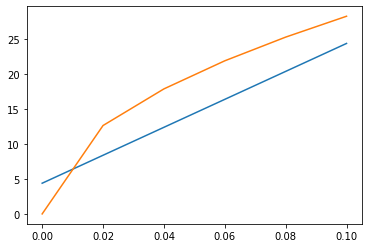

In [96]:
S = np.linspace(0, 0.1, 6) # rango a graficar 
m_0 = 0.05
K = np.linspace(0.0125,0.1,8)
k = 2000
replicator_discr = replicator_with_option_discr(S,m_0,K,k)

#Grafico el Strangle
plt.plot(S, replicator_discr)
plt.plot(S, 2*np.sqrt(k*S))
plt.show()

In [124]:
def replicador_with_option_CPM (m_T, m_0, k, eps, cot_sup):
    bond = value_bond(m_0, k)
    futures = notional_future(m_0,k)*payoff_futuro(m_T,m_0)
    x = sym.Symbol('x', real=True)
    f_call = -(1/2)*sym.sqrt(k/(x**3))* payoff_call(m_T, x)
    f_put = -(1/2)*sym.sqrt(k/(x**3))* payoff_put(m_T, x)
    int_calls =sym.integrate(f_call,(x, m_0, cot_sup))  
    int_puts = sym.integrate(f_put,(x, eps, m_0))
    return bond + futures + int_calls + int_puts
    

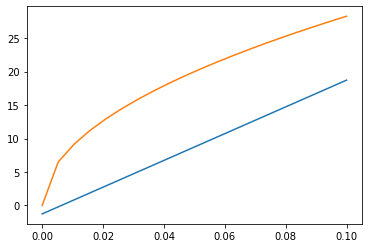

In [125]:
S = np.linspace(0, 0.1, 20) # rango a graficar 
m_0 = 0.05
k = 2000
eps =0.0001
cot_sup = 0.1
replicador = replicador_with_option_CPM(S, m_0, k, eps, cot_sup)

#Grafico el Strangle
plt.plot(S, replicador)
plt.plot(S, 2*np.sqrt(k*S))
plt.show()